In [4]:
import importlib
import unet

importlib.reload(unet)

from unet import UNet
from pathlib import Path
import sys
from train import SegmentationDataset
sys.path.append("..")

run_name = "20250510_112946_CCE_pls"
experiment_folder = Path("./runs") / run_name
model = UNet.load(experiment_folder)
model = model.to("cuda")

In [ ]:
import cv2
import numpy as np
from synthetic import DataGenerator, SynthSettings

# gen_settings = SynthSettings(
#     downscale_factor=0.5,
#     cutout_noise=True,
#     cutout_noise_size=200,
#     warp_noise=True,
#     warp_noise_strength=5
# )
# generator = DataGenerator(settings=gen_settings)
# _, segs, scrolls, lines = generator.generate_passages_scrolls(10, skip_char_seg=False)

# def resize(imgs: np.ndarray, factor: float):

#     height, width = imgs.shape[1:]
#     nh = int(height * factor)
#     nw = int(width * factor)

#     new_imgs = []
#     for img in imgs:
#         ri = cv2.resize(img, (nw, nh), interpolation=cv2.INTER_AREA)
#         new_imgs.append(ri)

#     return np.stack(new_imgs)

# scrolls = resize(scrolls, factor=0.5)
# lines = resize(lines, factor=0.5)

In [5]:
import pickle
import numpy as np


def load_batches(level: int):
    level_path = Path(".").resolve().parent / "data" / "scrolls_seg" / f"level_{level}"
    chunks = sorted(
        level_path.glob("chunk_*.npz"),
        key=lambda p: int(p.stem.split("_")[1])
    )

    for chunk_path in chunks:
        base = chunk_path.parent
        chunk = int(chunk_path.stem.split("_")[1])

        with open(base / f"chunk_{chunk}.pickle", "rb") as f:
            tokens: list[list[str]] = pickle.load(f) # not tokens but characters (batch, n_lines, sequence)

        data = np.load(chunk_path)
        scrolls: np.ndarray = data["scrolls"] # (batch, h, w)
        line_masks: np.ndarray = data["line_masks"] # (batch, h, w)
        segmentation_masks: np.ndarray = data["segmentation"] # (batch, 27, h, w)
        yield tokens, scrolls, line_masks, segmentation_masks

iterator = load_batches(level=0)
take_only = 10
indices = np.random.choice(500, size=take_only, replace=False)
_, val_scrolls, val_lines, val_seg = next(iterator)
val_seg = val_seg[indices]
val_lines = val_lines[indices]
val_scrolls = val_scrolls[indices]


In [ ]:
import numpy as np
import torch.nn as nn
import torch
from torch.utils.data import DataLoader
import torch.nn.functional as F

def inference(scrolls, segs= None, lines = None):

    track_loss = lines is not None

    if not track_loss:
        lines = np.empty((scrolls.shape[0], 0))

    data = SegmentationDataset(scrolls, segs, lines)
    criterion = nn.CrossEntropyLoss()
    hats = []
    model.eval()
    test_loss = []
    with torch.no_grad():
        for batch_scrolls, batch_seg_classes in DataLoader(data, batch_size=8):
            batch_scrolls, batch_seg_classes = batch_scrolls.to("cuda"), batch_seg_classes.to("cuda")
            hat = model(batch_scrolls)
            hats.append(F.softmax(hat, dim=1).cpu().numpy())

            if track_loss:
                loss = criterion(hat, batch_seg_classes)
                test_loss.append(loss.item())


    hats = np.concatenate(hats, axis=0)
    if track_loss:
        return hats, np.mean(test_loss)
    else:
        hats

hats, loss = inference(val_scrolls, val_seg, val_lines)
loss

np.float64(2.5842643651095303)

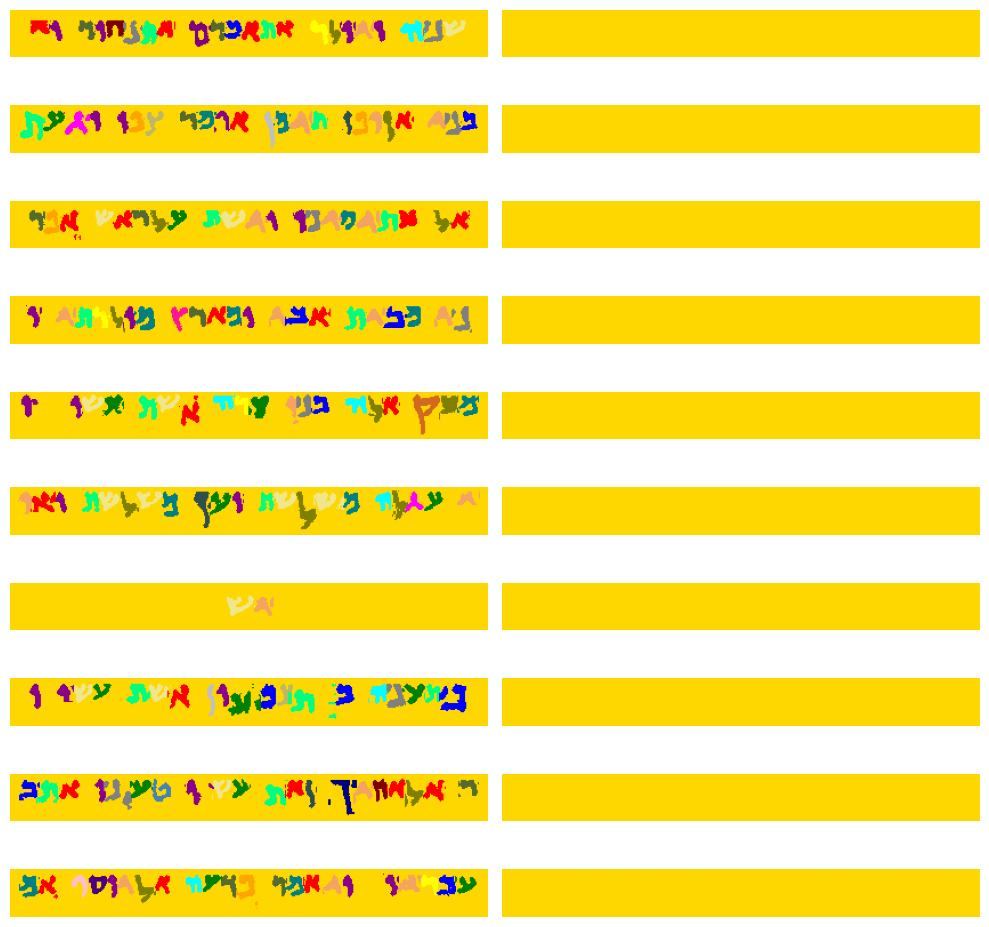

In [8]:
from matplotlib import pyplot as plt
import matplotlib.colors as mcolors

data = SegmentationDataset(val_scrolls, val_seg, val_lines)
b_indices = np.random.choice(len(data), size=10, replace=False)

fig, ax = plt.subplots(b_indices.size, 2, figsize=(10, 10))

colors = [
    "red", "green", "blue", "yellow", "magenta", "cyan", "maroon", "darkgreen", "navy",
    "olive", "purple", "teal", "silver", "gray", "orange", "pink", "chocolate", "darkolivegreen",
    "indigo", "khaki", "springgreen", "steelblue", "deeppink", "darkkhaki", "darkmagenta",
    "sandybrown", "darkslategray", "gold"
]
cmap = mcolors.ListedColormap(colors)

for i, b_i in enumerate(b_indices):

    _, truth = data[b_i]
    hat = np.argmax(hats[b_i], axis=0)

    ax[i, 0].imshow(truth, cmap=cmap, vmin=0, vmax=27)
    ax[i, 1].imshow(hat, cmap=cmap, vmin=0, vmax=27)

    ax[i, 0].set_axis_off()
    ax[i, 1].set_axis_off()


fig.tight_layout()
plt.show()


In [ ]:
_, c = np.unique(truth.numpy(), return_counts=True)

c = c / c.sum()
c

array([0.02540061, 0.01647915, 0.01011479, 0.00823957, 0.00778498,
       0.01022844, 0.02113877, 0.0124446 , 0.00744403, 0.01431981,
       0.00937607, 0.01909308, 0.02608251, 0.81185362])

In [34]:
t = torch.stack([x for (_, x) in data])
t = t.numpy()
v, c = np.unique(t, return_counts=True)
print(v)
c[0] / c[1]

[0. 1.]


np.float64(138.8114841385495)

In [ ]:
li, sm = data[index]

li = li.to("cuda")


x = li.unsqueeze(0)
x = model.enc1(x)
print(x.shape)
x = model.enc2(x)
print(x.shape)
x = model.enc3(x)
print(x.shape)
x = model.enc4(x)
print(x.shape)


torch.Size([1, 16, 25, 211])
torch.Size([1, 32, 13, 106])
torch.Size([1, 64, 7, 53])
torch.Size([1, 96, 4, 27])


In [46]:
truth.dtype

torch.float32